In [1]:
# Agregamos la ruta donde se encuentran las funciones de utilidad
import sys
sys.path.insert(0, '../utils/')

# Import de librerías necesarias
import analysis_functions as fnc
import bootcampviztools as btcvt
from variables import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mplt

from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu 
from scipy import stats

from functools import reduce


sns.set(color_codes=True)

In [2]:
df = pd.read_csv(TURISMO_ECO_ZERO_FILENAME_FINAL, sep=CSV_SEPARADOR_COLUMNAS, )
df.head()

,ID,PROVINCIA,MARCA,MODELO,PROVINCIA_MATR,FECHA_MATR,FECHA_PRIM_MATR,TIPO_DGT,CAT_EURO,RENTING,...,POTENCIA,KW,PROPULSION,CATELECT,CONSUMO,AUTONOMIA,ALIMENTACION,TIPO_DISTINTIVO,EMISIONES_EURO,EMISIONES_CO2
0,13,Huelva,RENAULT,ARKANA E-TECH,Segovia,2022-06-28,2022-06-28,TURISMOS,M1,N,...,11.64,69.0,Gasolina,(HEV) Eléctrico Híbrido,0.0,0.0,Monofuel,ECO,EURO 6AP,108.0
1,22,Girona,HYUNDAI,KONA,Granada,2022-03-07,2022-03-07,TURISMOS,M1,N,...,11.56,77.2,Gasolina,(HEV) Eléctrico Híbrido,0.0,0.0,Monofuel,ECO,EURO 6AP,112.0
2,36,Alicante,KIA,NIRO,Álava,2018-03-28,2018-03-28,TURISMOS,M1,N,...,11.56,77.2,Gasolina,(HEV) Eléctrico Híbrido,0.0,0.0,Monofuel,ECO,EURO 6W,88.0
3,106,Ciudad Real,LEXUS,LEXUS NX300H,Madrid,2016-03-29,2016-03-29,TURISMOS,M1,N,...,0.15,114.0,Gasolina,(HEV) Eléctrico Híbrido,0.0,0.0,Monofuel,ECO,EURO 6W,121.0
4,143,Alicante,FORD,PUMA,La Coruña,2021-12-16,2021-12-16,TURISMOS,M1,N,...,7.82,91.9,Gasolina,(HEV) Eléctrico Híbrido,0.0,0.0,Monofuel,ECO,EURO 6AP,129.0


In [3]:
# Cambiamos el nombre de la columna 'Unnamed: 0' generada con el ID del archivo anterior y lo establecemos como indice.
#df.rename(columns = {"Unnamed: 0":"ID"}, inplace = True)
df.set_index('ID',inplace=True)

In [4]:
# Patrón para transformar a fechas los campos FECHA_MATR, FECHA_PRIM_MATR
patron = "%Y-%m-%d"

# ******* Campo: FECHA_MATR *******
df.FECHA_MATR = pd.to_datetime(df.FECHA_MATR, format = patron)

# ******* Campo: FECHA_PRIM_MATR *******
df.FECHA_PRIM_MATR = pd.to_datetime(df.FECHA_PRIM_MATR, format = patron)

In [5]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1620160 entries, 13 to 37890848
Data columns (total 22 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   PROVINCIA        1620160 non-null  object        
 1   MARCA            1620160 non-null  object        
 2   MODELO           1620160 non-null  object        
 3   PROVINCIA_MATR   1620160 non-null  object        
 4   FECHA_MATR       1620160 non-null  datetime64[ns]
 5   FECHA_PRIM_MATR  1620160 non-null  datetime64[ns]
 6   TIPO_DGT         1620160 non-null  object        
 7   CAT_EURO         1620160 non-null  object        
 8   RENTING          1620160 non-null  object        
 9   TARA             1620160 non-null  int64         
 10  PESO_MAX         1620160 non-null  int64         
 11  CILINDRADA       1620160 non-null  int64         
 12  POTENCIA         1620160 non-null  float64       
 13  KW               1620160 non-null  float64       
 14  PROPU

In [6]:
columns_categoricas = ['PROVINCIA', 'MARCA', 'MODELO', 'PROVINCIA_MATR', 'CAT_EURO', 
                       'RENTING', 'PROPULSION', 'CATELECT', 'ALIMENTACION', 'TIPO_DISTINTIVO', 
                       'EMISIONES_EURO'
]

columns_categoricas_binarias = ['RENTING','TIPO_DISTINTIVO']

columns_numericas =  ['FECHA_MATR', 'FECHA_PRIM_MATR', 'TARA', 'PESO_MAX', 'CILINDRADA', 
                      'POTENCIA', 'KW', 'CONSUMO', 'AUTONOMIA', 'EMISIONES_CO2'
]

In [8]:
# Función que devuelve el dataframe filtrado con las condiciones especificadas en cond_list
def get_dataframe(df, cond_list = []):
    return df.loc[reduce(np.logical_and, cond_list)]

# En este caso, por defecto lo vamos a restringir a valores posteriores a 2019
def get_dataframe_estudio(df, date_column, cond_list = []):
    conds = cond_list.copy()
    conds.append(df[date_column] >= "01-01-2019")
    return get_dataframe(df, cond_list = conds)

# Devuelve el dataframe con la FECHA_MATR posterior a 2019
def get_dataframe_estudio_FECHA_MATR(df, cond_list = []):
    return get_dataframe_estudio(df, "FECHA_MATR", cond_list)

d:\# DATA\PROJECTS\DATA SCIENCE\# Documentación\Project_Break_I__EDA\Project\Microdatos de parque de vehículos (anual)\notebooks\../utils\analysis_functions.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


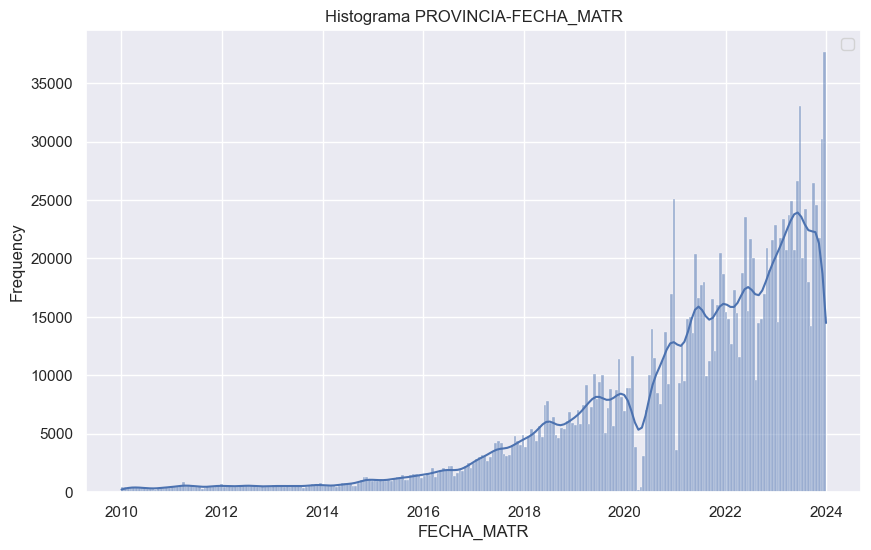

In [8]:
# Evolución de las ventas de vehiculos desde 2019
fnc.plot_categorica_numerica_histogram(get_dataframe(df, cond_list=[df.FECHA_MATR>="01-01-2010"]), "PROVINCIA", "FECHA_MATR")

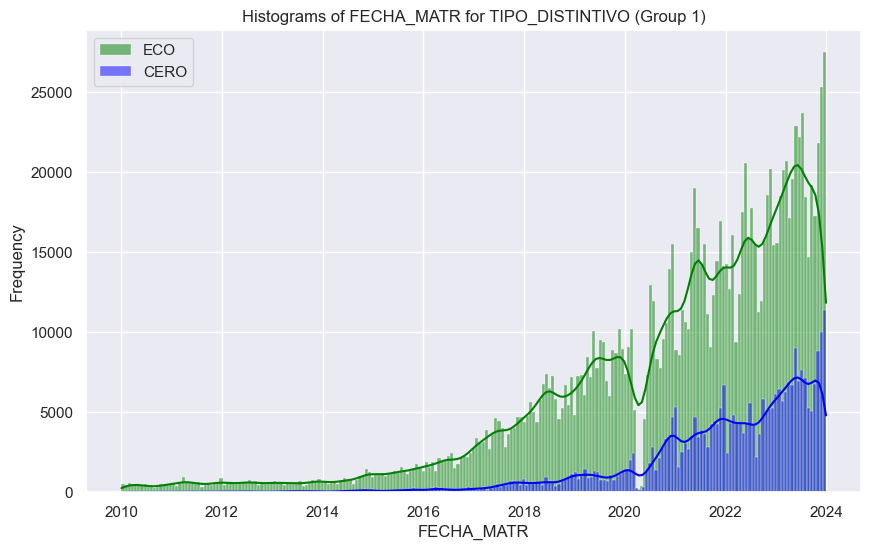

In [9]:
# Evolucón de ventas desde 2010 según etiqueta
btcvt.plot_grouped_histograms(get_dataframe(df, cond_list=[df.FECHA_MATR>="01-01-2010"]), "TIPO_DISTINTIVO", "FECHA_MATR", group_size= 2, dict_colors={"ECO": "green","CERO":"blue"})

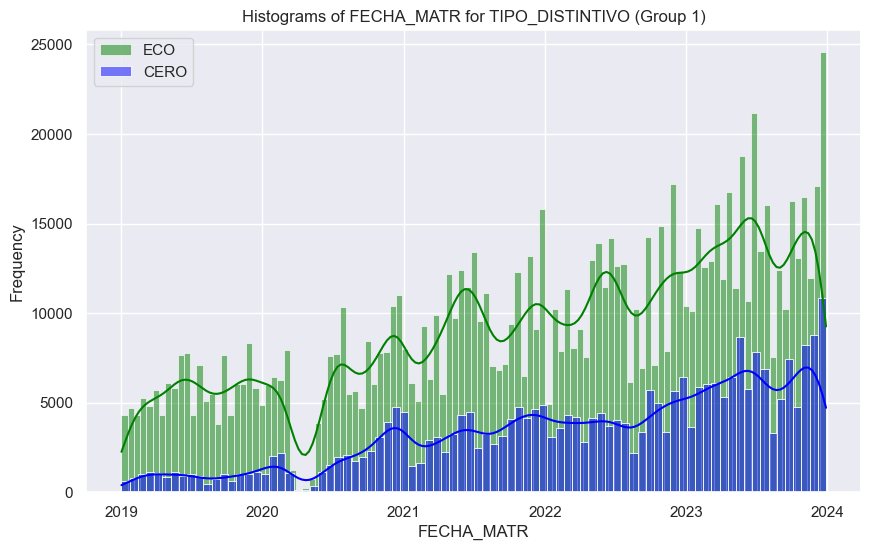

In [10]:
#Hacemos un análisis desde 2019
btcvt.plot_grouped_histograms(get_dataframe_estudio_FECHA_MATR(df), "TIPO_DISTINTIVO", "FECHA_MATR", group_size= 2, dict_colors={"ECO": "green","CERO":"blue"})

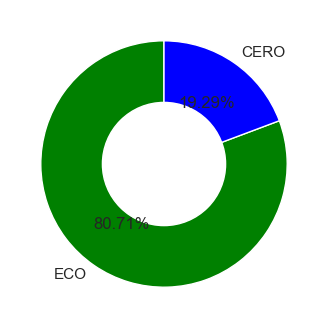

In [11]:
# Distribución de distintivo ECO-CERO
data = df["TIPO_DISTINTIVO"].value_counts()
fig,ax = plt.subplots(1,1,figsize = (4,4))
ax.pie(data.values,labels=data.index,autopct='%.2f%%', startangle= 90, colors=["green", "blue"])
my_circle=plt.Circle( (0,0), 0.5, #Grosor del donut
                     color="white")
ax.add_artist(my_circle)

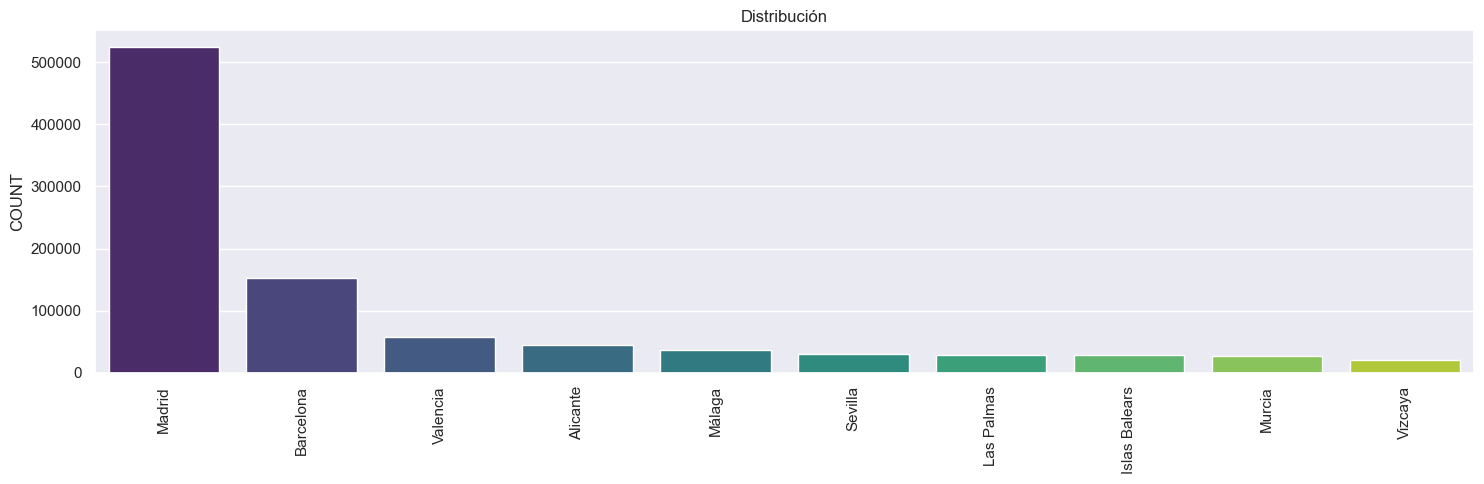

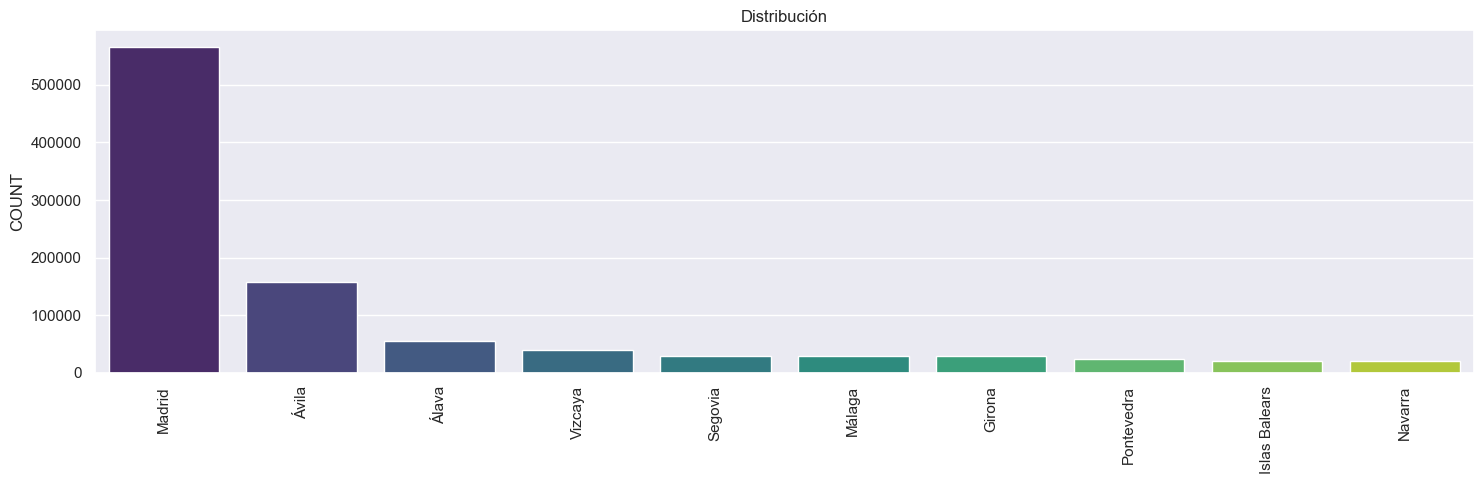

In [12]:
# Distribución de vehiculos por provincia, dónde está domiciliado un coche y dónde se matriculó
fnc.pinta_hist_count_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df), "PROVINCIA","FECHA_MATR",10)
fnc.pinta_hist_count_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df), "PROVINCIA_MATR","FECHA_MATR",10)

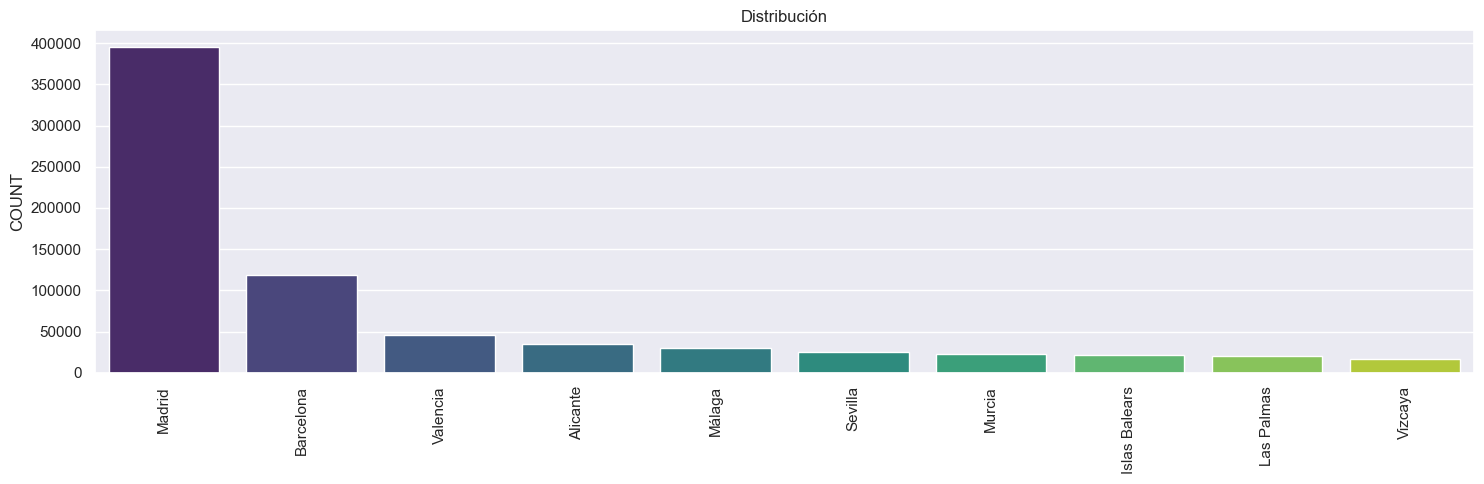

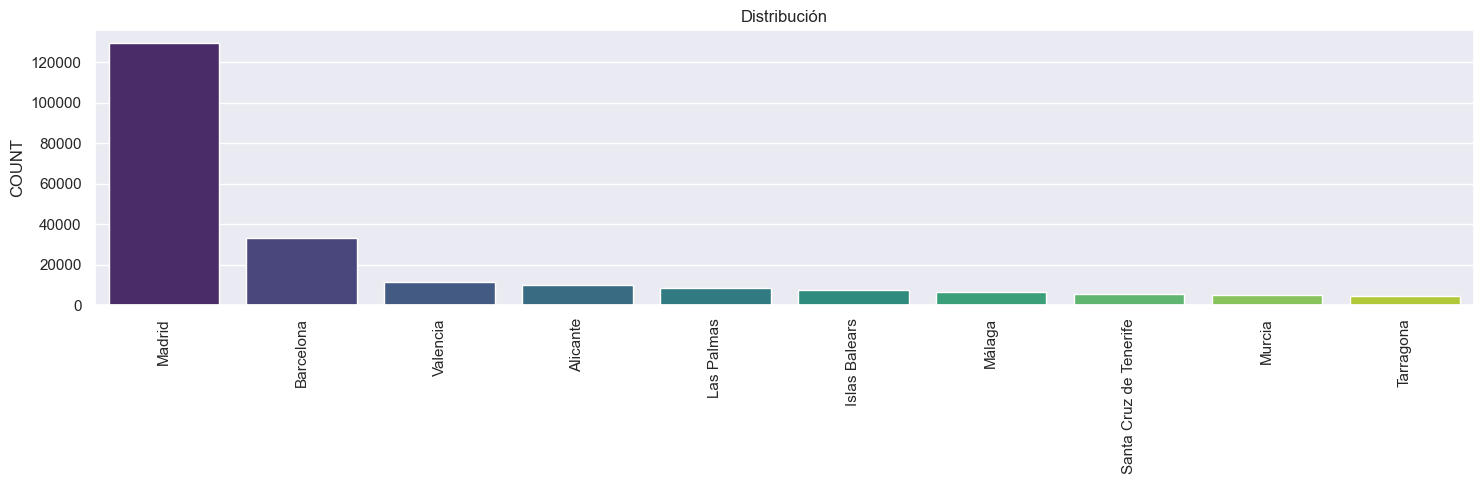

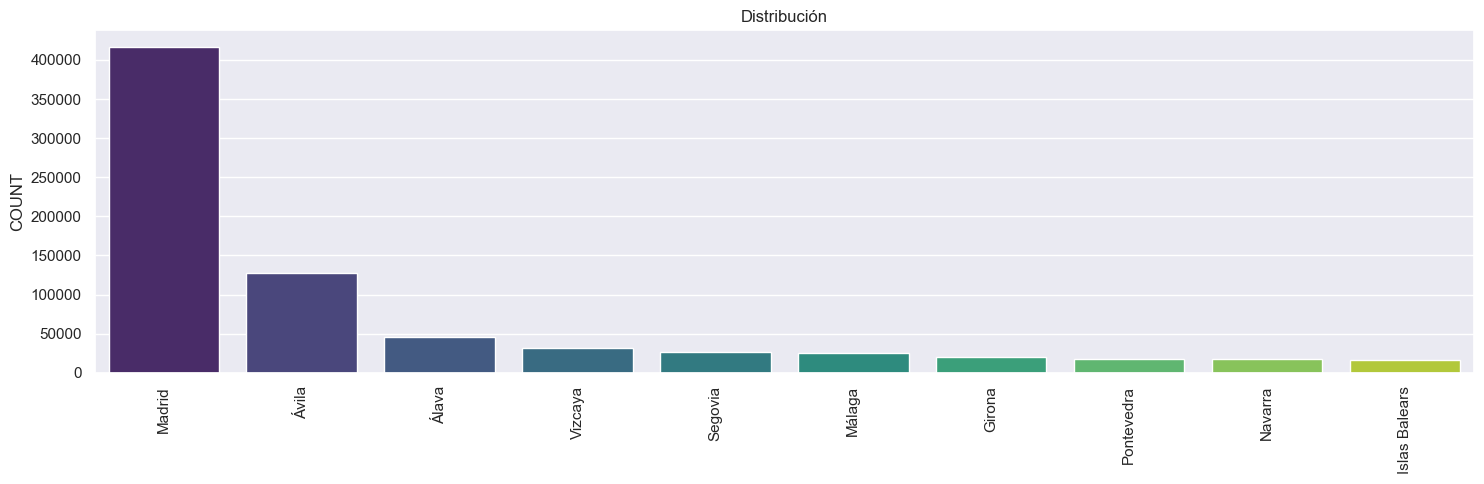

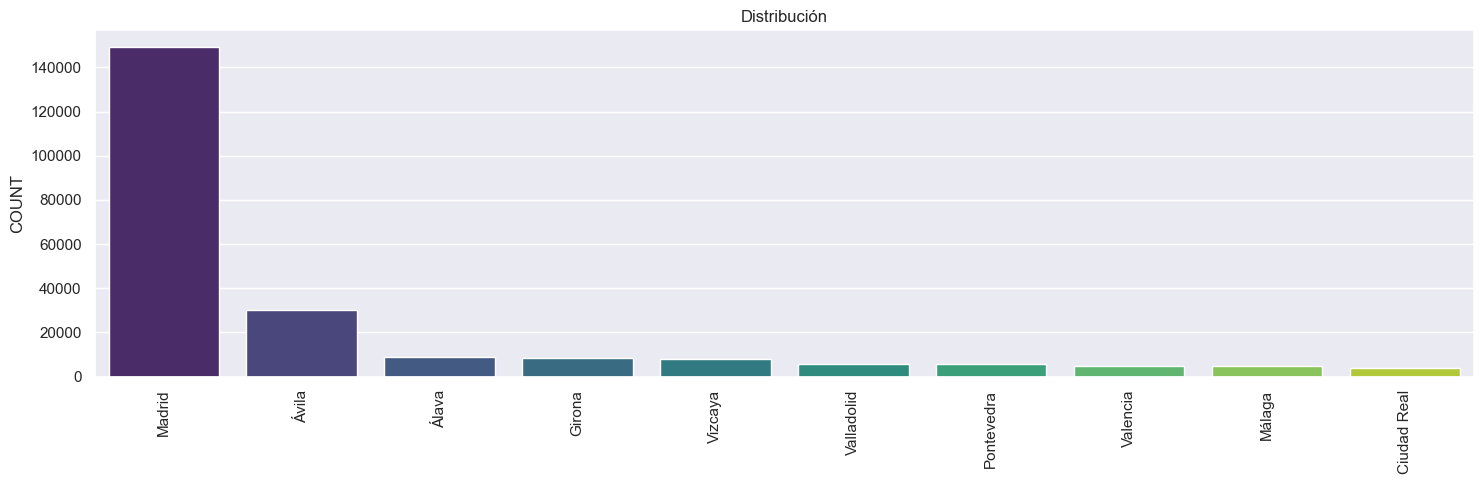

In [13]:
# Distribución de vehiculos por provincia y tipo de distintivo (ECO-CERO), dónde está domiciliado un coche y dónde se matriculó, 
# para ver si hay diferencias respecto al agrupado
fnc.pinta_hist_count_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.TIPO_DISTINTIVO == "ECO"]), "PROVINCIA","FECHA_MATR",10)
fnc.pinta_hist_count_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.TIPO_DISTINTIVO == "CERO"]), "PROVINCIA","FECHA_MATR",10)

fnc.pinta_hist_count_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.TIPO_DISTINTIVO == "ECO"]), "PROVINCIA_MATR","FECHA_MATR",10)
fnc.pinta_hist_count_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.TIPO_DISTINTIVO == "CERO"]), "PROVINCIA_MATR","FECHA_MATR",10)

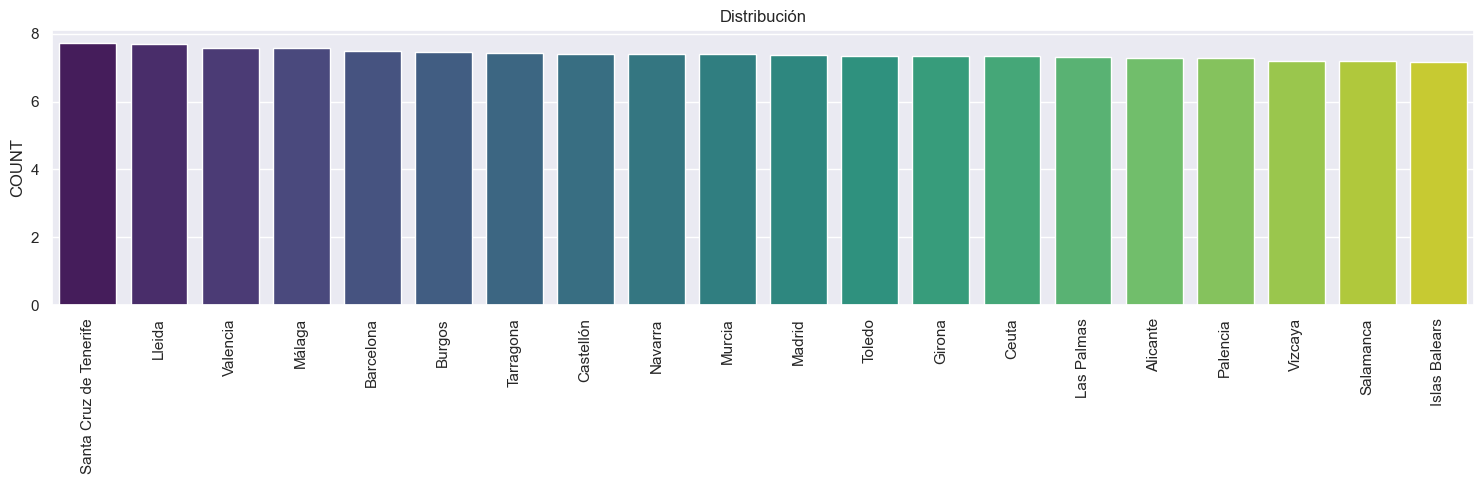

In [14]:
#Relación entre la provincia y la media de la potencia de los coches matriculados
fnc.pinta_hist_mean_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df), "PROVINCIA","POTENCIA", 20)

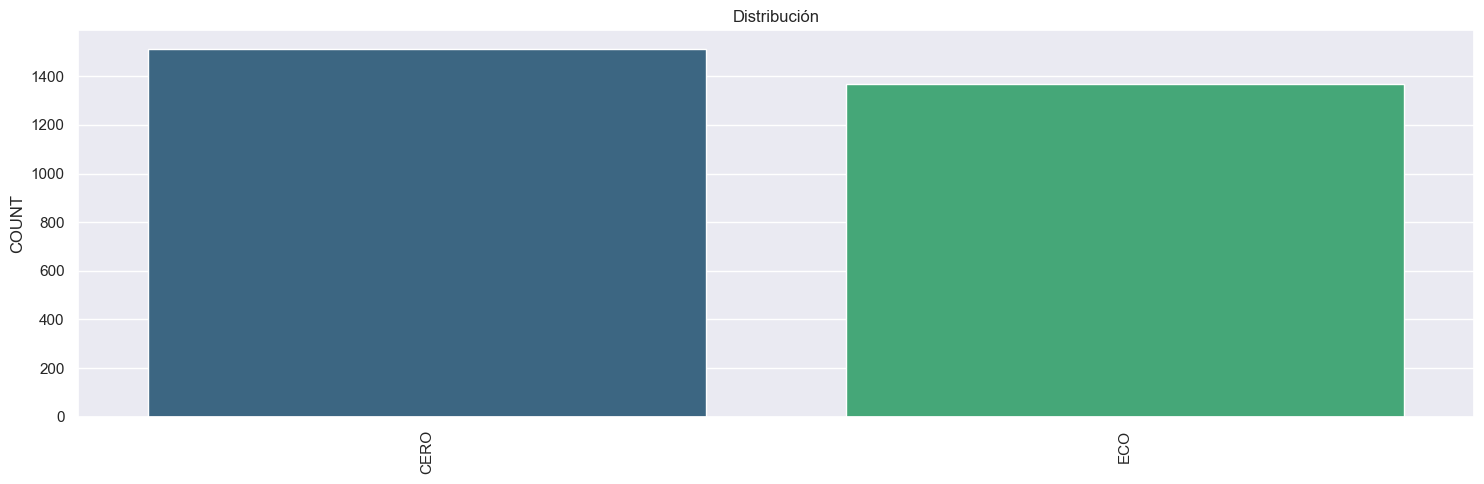

In [15]:
#Media de la tara de los vehículos según distintivos
fnc.pinta_hist_mean_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df), "TIPO_DISTINTIVO","TARA", 20)

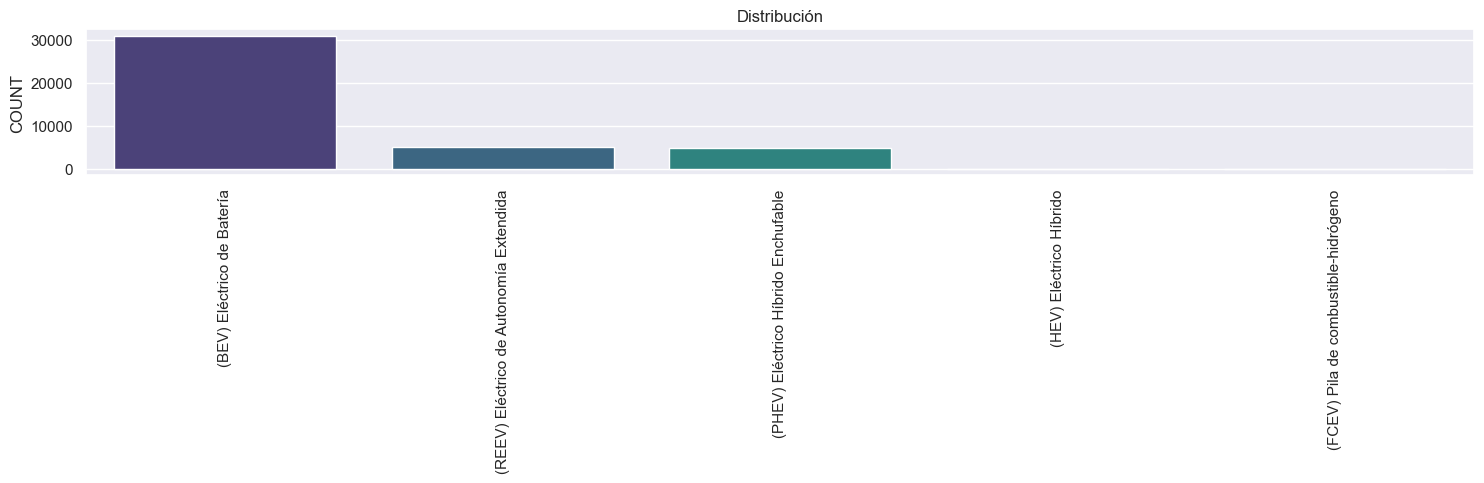

In [23]:
#Media de la autonomima de los vehículos según la categoría electrica del vehiculo
fnc.pinta_hist_mean_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.CATELECT != VALUE_SIN_DETERMINAR]), "CATELECT","AUTONOMIA",20)

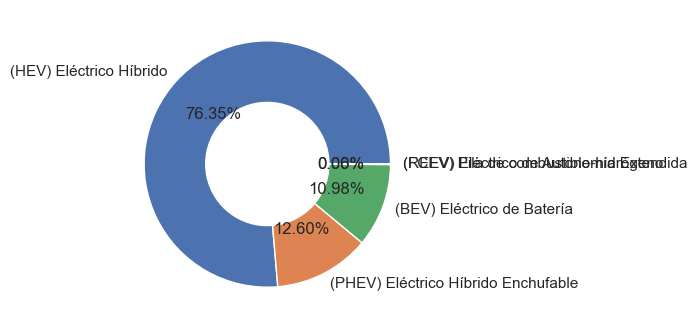

In [29]:
# Distribución de distintivo ECO-CERO
df_aux = get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.CATELECT != VALUE_SIN_DETERMINAR])
data = df_aux["CATELECT"].value_counts()
fig,ax = plt.subplots(1,1,figsize = (4,4))
ax.pie(data.values,labels=data.index,autopct='%.2f%%')
my_circle=plt.Circle( (0,0), 0.5, #Grosor del donut
                     color="white")
ax.add_artist(my_circle)

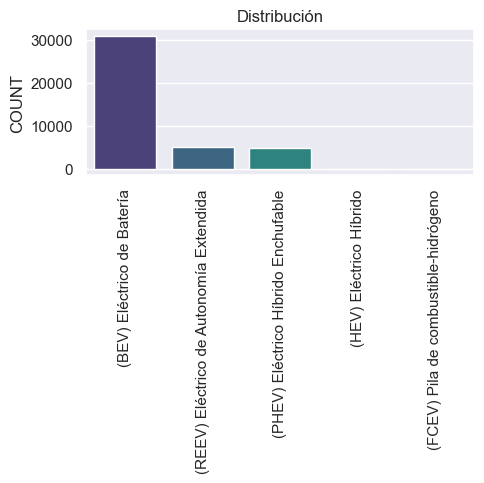

In [11]:
#Media de la tara de los vehículos según la categoría electrica del vehiculo
fnc.pinta_hist_mean_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.CATELECT != VALUE_SIN_DETERMINAR]), "CATELECT","AUTONOMIA",20, figsize=(5,5))

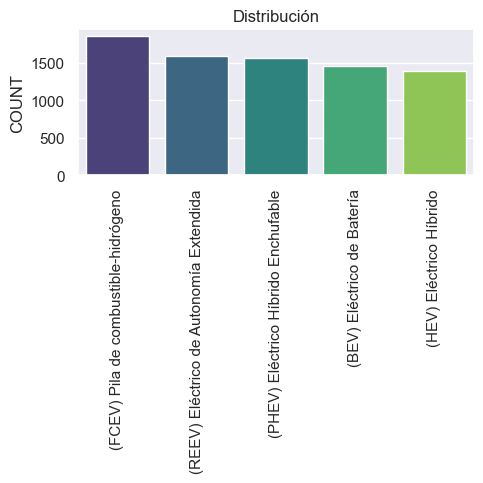

In [ ]:
#Media de la tara de los vehículos según la categoría electrica del vehiculo
fnc.pinta_hist_mean_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.CATELECT != VALUE_SIN_DETERMINAR]), "CATELECT","TARA",20, figsize=(5,5))


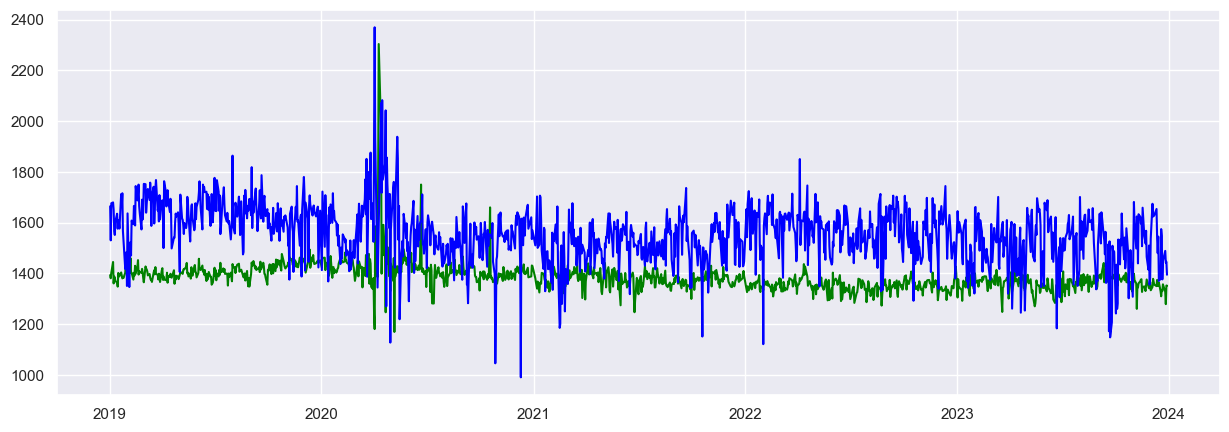

In [17]:
#Evolución temporal de la tara desde 2019
df_aux = get_dataframe_estudio_FECHA_MATR(df, [df.TARA != NUM_VALUE_SIN_DETERMINAR])
tipo_distintivo_values = {"ECO":"green", "CERO": "blue"}

fnc.pinta_categorica_numerica_fecha(df_aux, "TIPO_DISTINTIVO", "FECHA_MATR","TARA",  dict_colors=tipo_distintivo_values)

C:\Users\justo\AppData\Local\Temp\ipykernel_100\1657165506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux["AÑO"] = df_aux["FECHA_MATR"].dt.year


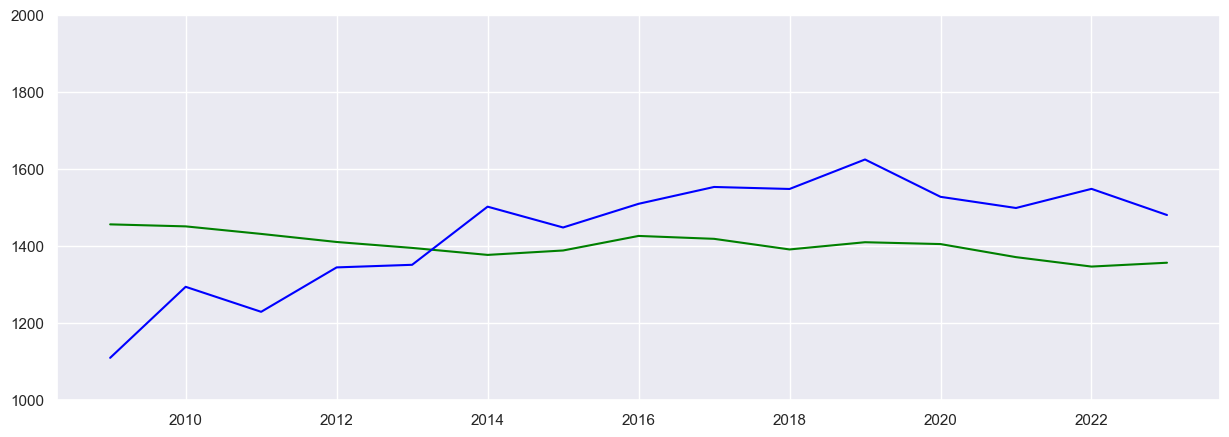

In [18]:
#Evolución temporal de la tara desde 2009 agrupado por años
df_aux = df.loc[(df["FECHA_MATR"] >= "01-01-2009") & (df.TARA != NUM_VALUE_SIN_DETERMINAR)] #get_dataframe_estudio_FECHA_MATR(df, [df.TARA != NUM_VALUE_SIN_DETERMINAR])
df_aux["AÑO"] = df_aux["FECHA_MATR"].dt.year

tipo_distintivo_values = {"ECO":"green", "CERO": "blue"}

fnc.pinta_categorica_numerica_fecha(df_aux, "TIPO_DISTINTIVO", "AÑO","TARA",  dict_colors=tipo_distintivo_values, ylim=(1000,2000))



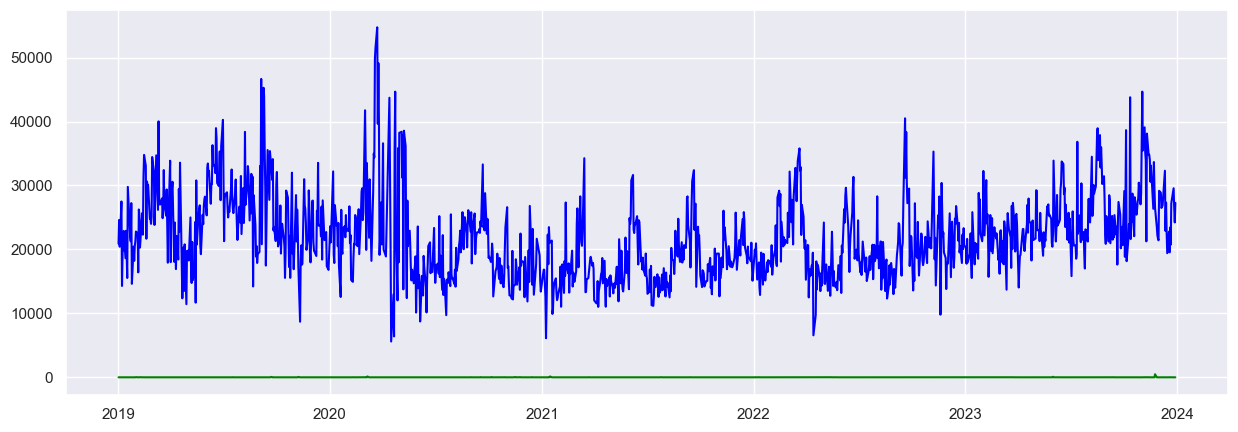

In [19]:
#Evolución temporal de la autonomía de los vehiculos desde 2019
df_aux = get_dataframe_estudio_FECHA_MATR(df, [df.AUTONOMIA != NUM_VALUE_SIN_DETERMINAR])
tipo_distintivo_values = {"ECO":"green", "CERO": "blue"}

fnc.pinta_categorica_numerica_fecha(df_aux, "TIPO_DISTINTIVO", "FECHA_MATR","AUTONOMIA",  dict_colors=tipo_distintivo_values)

C:\Users\justo\AppData\Local\Temp\ipykernel_100\1780332363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux["AÑO"] = df_aux["FECHA_MATR"].dt.year


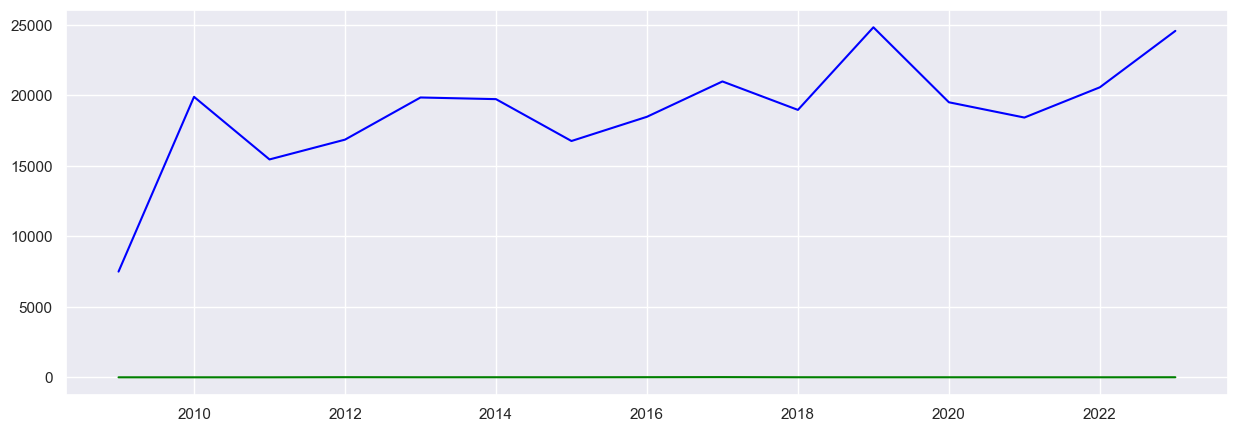

In [20]:
#Evolución temporal de la autonomía de los vehiculos desde 2009 agrupado por años
df_aux = df.loc[(df["FECHA_MATR"] >= "01-01-2009") & (df.AUTONOMIA != NUM_VALUE_SIN_DETERMINAR)] #get_dataframe_estudio_FECHA_MATR(df, [df.TARA != NUM_VALUE_SIN_DETERMINAR])
df_aux["AÑO"] = df_aux["FECHA_MATR"].dt.year

tipo_distintivo_values = {"ECO":"green", "CERO": "blue"}

fnc.pinta_categorica_numerica_fecha(df_aux, "TIPO_DISTINTIVO", "AÑO","AUTONOMIA",  dict_colors=tipo_distintivo_values)

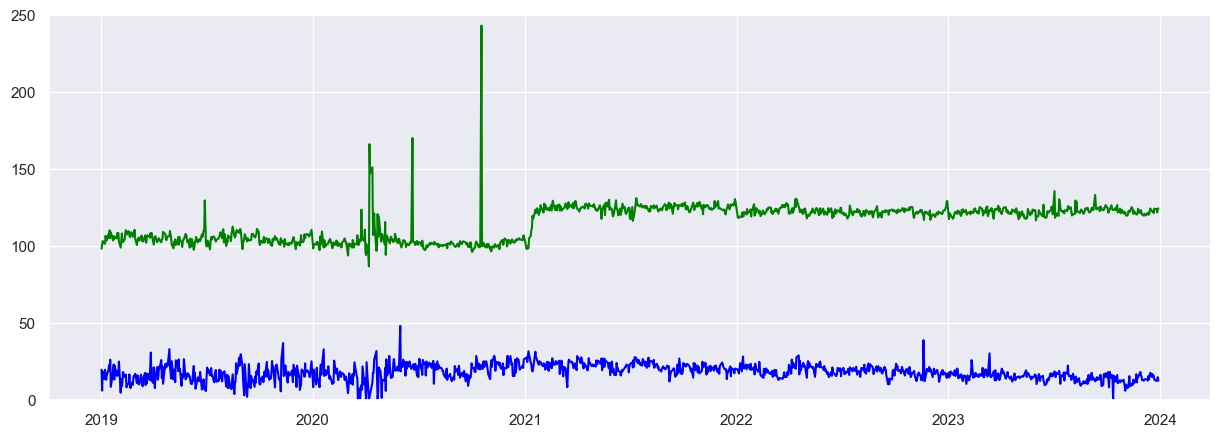

In [21]:
#Evolución temporal de laas emisiones de CO2 de los vehiculos desde 2019
df_aux = get_dataframe_estudio_FECHA_MATR(df, [df.EMISIONES_CO2 != NUM_VALUE_SIN_DETERMINAR])
tipo_distintivo_values = {"ECO":"green", "CERO": "blue"}

fnc.pinta_categorica_numerica_fecha(df_aux, "TIPO_DISTINTIVO", "FECHA_MATR","EMISIONES_CO2",  dict_colors=tipo_distintivo_values, ylim=(0,250))

C:\Users\justo\AppData\Local\Temp\ipykernel_100\4181467181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux["AÑO"] = df_aux["FECHA_MATR"].dt.year


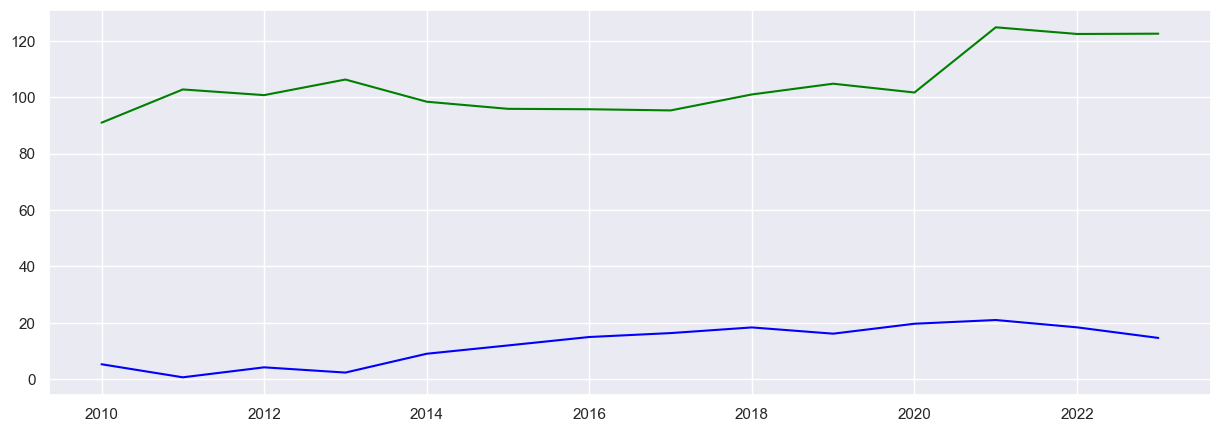

In [22]:
#Evolución temporal de laas emisiones de CO2 de los vehiculos desde 2009 agrupado por años
df_aux = df.loc[(df["FECHA_MATR"] >= "01-01-2010") & (df.EMISIONES_CO2 != NUM_VALUE_SIN_DETERMINAR)] #get_dataframe_estudio_FECHA_MATR(df, [df.TARA != NUM_VALUE_SIN_DETERMINAR])
df_aux["AÑO"] = df_aux["FECHA_MATR"].dt.year

tipo_distintivo_values = {"ECO":"green", "CERO": "blue"}

fnc.pinta_categorica_numerica_fecha(df_aux, "TIPO_DISTINTIVO", "AÑO","EMISIONES_CO2",  dict_colors=tipo_distintivo_values)


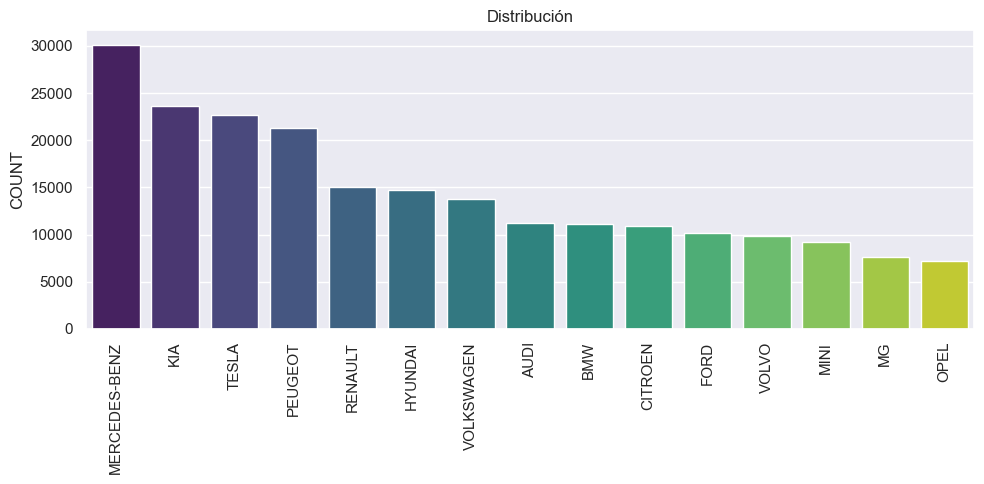

In [46]:
#Relación de las MARCAS
fnc.pinta_hist_count_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.MARCA != VALUE_SIN_DETERMINAR, df.TIPO_DISTINTIVO == "CERO"]), "MARCA","PROVINCIA", 15)

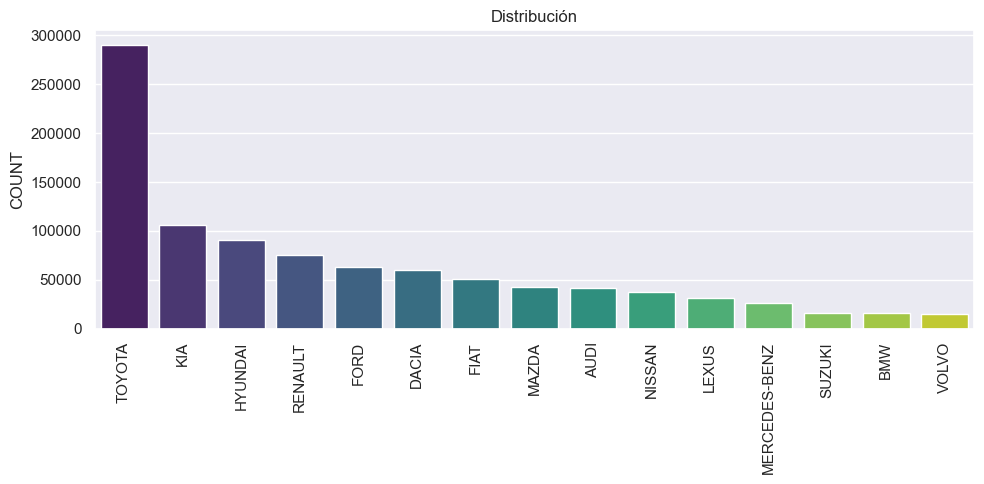

In [47]:
#Relación de las MARCAS
fnc.pinta_hist_count_categorica_numerica(get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.MARCA != VALUE_SIN_DETERMINAR, df.TIPO_DISTINTIVO == "ECO"]), "MARCA","PROVINCIA", 15)

['FORD' 'KIA' 'RENAULT' 'TESLA' 'TOYOTA']


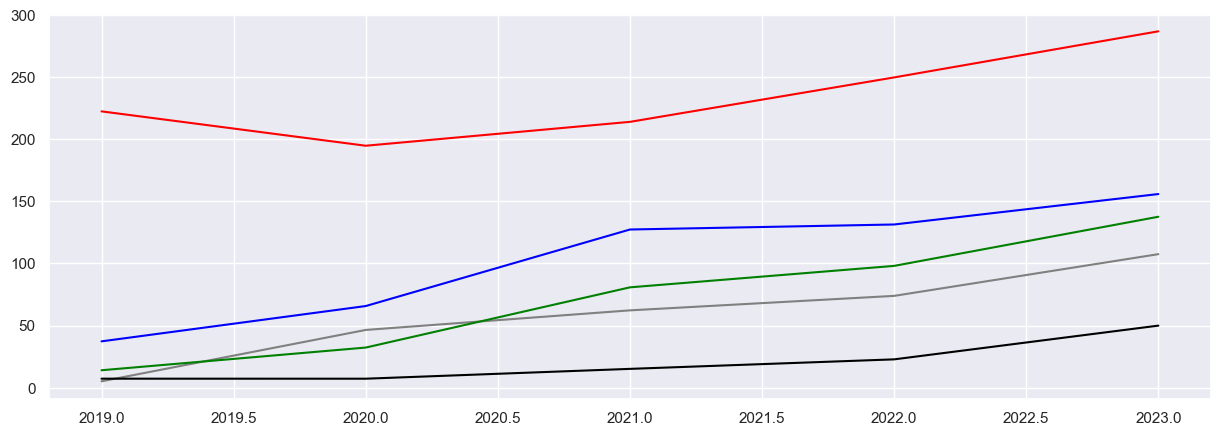

In [45]:
#Relación entre la MARCA
df_aux = get_dataframe_estudio_FECHA_MATR(df, cond_list=[df.MARCA.isin(["TOYOTA","KIA","RENAULT","FORD","TESLA"]) ] )
df_aux = pd.DataFrame(df_aux.groupby(["FECHA_MATR","MARCA",])["PROVINCIA"].count())
df_aux.reset_index(drop = False, inplace=True)
#display(df_aux)

df_aux["AÑO"] = df_aux["FECHA_MATR"].dt.year
print(df_aux.MARCA.unique())

fnc.pinta_categorica_numerica_fecha(df_aux, "MARCA", "AÑO", "PROVINCIA", dict_colors={"TOYOTA":"red","KIA":"blue","RENAULT":"green","FORD":"grey","TESLA":"black"})
